In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys 
import commot as ct

sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
from spaceoracle.tools.network import get_mouse_housekeeping_genes
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels

import celloracle as co

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
base_GRN = co.data.load_mouse_promoter_base_GRN()

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [4]:
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='mouse', 
        signaling_type="Secreted Signaling"
        # signaling_type=None
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

In [5]:
from collections import Counter

In [6]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/slideseq/day3_1.h5ad')
adata

AnnData object with n_obs × n_vars = 15920 × 24649
    obs: 'cluster', 'rctd_cluster'
    uns: 'cluster_colors', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'

In [7]:
adata = adata[:, ~adata.var_names.str.endswith('Rik')]
adata = adata[:, ~adata.var_names.str.contains(r'^Hb\w+-\w+$')]
adata = adata[:, ~adata.var_names.str.contains('Hp')]
adata = adata[:, ~adata.var_names.str.startswith('Rp')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5s')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5')]
adata = adata[:, ~adata.var_names.str.startswith('AA')]
adata = adata[:, ~adata.var_names.str.startswith('AB')]
adata = adata[:, ~adata.var_names.str.startswith('AC')]
adata = adata[:, ~adata.var_names.str.startswith('Gm')]
adata = adata[:, ~adata.var_names.str.startswith('Mir')]
adata = adata[:, adata.var.index.str.len() > 1]
adata = adata[:, [i for i in adata.var_names if not (i[:2].isupper() and i[:2].isalpha())]]
adata = adata[:, [gene for gene in adata.var_names if not gene[-4:].isdigit()]]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 15920 × 15573
    obs: 'cluster', 'rctd_cluster'
    uns: 'cluster_colors', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'

In [9]:
housekeeping_db = get_mouse_housekeeping_genes()

In [10]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]
adata = adata[:, ~adata.var_names.isin(housekeeping_db['Gene'].unique())]
adata.layers["raw_count"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [11]:
adata.layers["normalized_count"] = adata.to_df().values.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)
adata.X = adata.layers["raw_count"].copy()
adata

AnnData object with n_obs × n_vars = 15836 × 12383
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count', 'normalized_count'

In [12]:
sc.pp.filter_genes(adata, min_counts=1)

In [13]:
adata.obs['cell_type'] = adata.obs['rctd_cluster'].cat.rename_categories(
    {
        0: "B-cell",
        1: "Cd8 T-cell",
        2: "Th2",
        3: "Resting T-cell",
        4: "Tfh",
        5: "Treg",
        6: "NK"
    }
)

In [14]:
ligand_receptor_genes = np.intersect1d(
    adata.var_names, 
    df_ligrec.ligand.unique().tolist()+df_ligrec.receptor.unique().tolist())

In [15]:
lr_df = adata.to_df(layer='normalized_count').join(
    adata.obs.cell_type).groupby('cell_type').mean()[
        ligand_receptor_genes].mean().sort_values(ascending=False).to_frame().reset_index()
lr_df.columns = ['genes', 'expr']

In [16]:
lr_df['mean_expr'] = lr_df['genes'].apply(lambda x: adata.to_df(layer='normalized_count')[x].mean())

In [17]:
adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(
    [
        'Cxcl12','Cxcr4', 'Mif', 'Il2', 'Il4', 
        'Il2ra', 'Pax5', 'Bach2', 'Prdm1', 
        'Bcl6', 'Foxp3'
    ] + lr_df.query('expr > 0.005').genes.to_list()
))]


In [18]:
adata

View of AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_counts'
    uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count', 'normalized_count'

In [19]:
%matplotlib inline

In [20]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

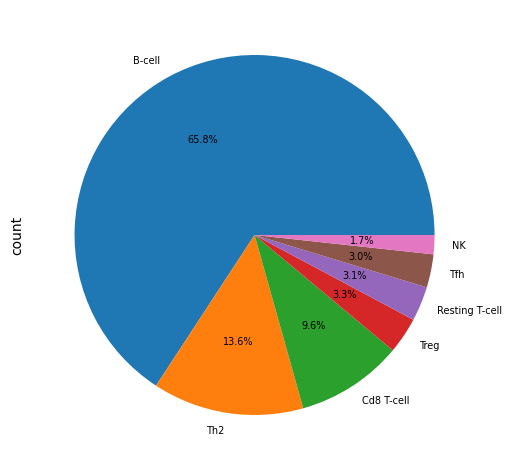

In [21]:
%matplotlib inline
adata.obs['cell_type'].value_counts().plot.pie(autopct='%.1f%%', fontsize=7)
plt.tight_layout()
plt.show()

In [22]:
for key in ['n_genes', 'n_UMIs', 'log10_n_UMIs', 'log10_n_genes',
       'cell_type_ontology_term_id', 'organism_ontology_term_id',
       'tissue_ontology_term_id', 'assay_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'donor_id', 'is_primary_data', 'suspension_type', 'tissue_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'observation_joinid',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_MT',
       'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt']:
    if key in adata.obs.keys():
        adata.obs.pop(key)

for key in ['gene', 'n_beads', 'n_UMIs', 'feature_is_filtered', 'feature_name',
       'feature_reference', 'feature_biotype', 'feature_length',
       'feature_type', 'MT', 'RP', 'n_cells_by_counts', 'mean_counts',
       'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts',
       'log1p_total_counts', 'n_cells', 'highly_variable', 'means',
       'dispersions', 'dispersions_norm']:
    if key in adata.var.keys():
        adata.var.pop(key)

del adata.uns

In [23]:
adata.var.drop(columns=['mt'], inplace=True)

In [24]:
adata

AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count', 'normalized_count'

In [25]:
pcs = BaseTravLR.perform_PCA(adata)
BaseTravLR.knn_imputation(adata, pcs, method='MAGIC')

Calculating MAGIC...
  Running MAGIC on 15836 cells and 3069 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.53 seconds.
    Calculating KNN search...
    Calculated KNN search in 20.38 seconds.
    Calculating affinities...
    Calculated affinities in 20.23 seconds.
  Calculated graph and diffusion operator in 49.17 seconds.
  Calculating imputation...
  Calculated imputation in 1.63 seconds.
Calculated MAGIC in 50.82 seconds.


In [26]:
from spaceoracle.plotting.cartography import xy_from_adata

xy = xy_from_adata(adata)

In [27]:
adata

AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count', 'normalized_count', 'imputed_count'

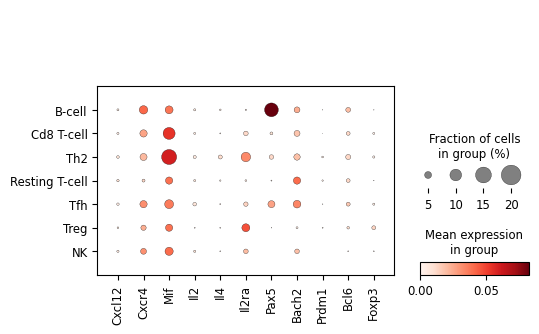

In [28]:

sc.pl.dotplot(
    adata, 
    ['Cxcl12','Cxcr4', 'Mif', 'Il2', 'Il4', 'Il2ra', 'Pax5', 'Bach2', 'Prdm1', 
     'Bcl6', 'Foxp3'], groupby='cell_type', 
    layer='normalized_count')

In [29]:
adata

AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count', 'normalized_count', 'imputed_count'

In [30]:
adata.write_h5ad('/Users/koush/Desktop/training_data/mLND3-1_v4.h5ad')